In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

Using TensorFlow backend.


In [2]:
data_path = 'data/'
images = 'images/'

In [3]:
droids_df = pd.read_pickle(f'{data_path}droids_df.pkl')

In [4]:
num_classes = 2
SHAPE_WIDTH = 80
SHAPE_HEIGHT = 120

In [5]:
def resize_pack(pack):
    fx_ratio = SHAPE_WIDTH / pack.shape[1]
    fy_ratio = SHAPE_HEIGHT / pack.shape[0]    
    pack = cv2.resize(pack, (0, 0), fx=fx_ratio, fy=fy_ratio)
    return pack[0:SHAPE_HEIGHT, 0:SHAPE_WIDTH]

In [6]:
x, y, f = [], [], []
for fileName, is_train in droids_df[['fileName', 'is_train']].values:
    droids_rects = droids_df.loc[droids_df['fileName'] == fileName]
    rects_data = droids_rects[['category', 'xmin', 'ymin', 'xmax', 'ymax']]
    im = cv2.imread(f'{images}{fileName}.jpg')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for category, xmin, ymin, xmax, ymax in rects_data.values:
        if category == 0:
            continue
        pack = resize_pack(np.array(im[ymin:ymax, xmin:xmax]))
        x.append(pack)
        f.append(is_train)
        y.append(int(category) - 1)

In [7]:
model = keras.models.load_model('my_model/top_model.h5', compile=False)

In [8]:
# let's split the data to train/validation sets based on our is_train flag
x = np.array(x)
y = np.array(y)
f = np.array(f)
x_train, x_test, y_train, y_test = x[f], x[~f], y[f], y[~f]
# save test images
x_test_images = x_test

In [9]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [11]:
image_generator_1 = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images)
image_generator_2 = ImageDataGenerator(rotation_range=45, vertical_flip=True)
image_generator_3 = ImageDataGenerator(rotation_range=30)
image_generator_4 = ImageDataGenerator(horizontal_flip=True)
image_generator_5 = ImageDataGenerator()

In [12]:
batch_size = len(x_test)
test_data_gen_1 = image_generator_1.flow(x_test, y_test, batch_size=batch_size)
test_data_gen_2 = image_generator_2.flow(x_test, y_test, batch_size=batch_size)
test_data_gen_3 = image_generator_3.flow(x_test, y_test, batch_size=batch_size)
test_data_gen_4 = image_generator_4.flow(x_test, y_test, batch_size=batch_size)
test_data_gen_5 = image_generator_5.flow(x_test, y_test, batch_size=batch_size)

In [13]:
test_images_1, test_labels_1 = next(test_data_gen_1)
test_images_2, test_labels_2 = next(test_data_gen_2)
test_images_3, test_labels_3 = next(test_data_gen_3)
test_images_4, test_labels_4 = next(test_data_gen_4)
test_images_5, test_labels_5 = next(test_data_gen_5)

test_images = np.concatenate((test_images_1, test_images_2))
test_images = np.concatenate((test_images, test_images_3))
test_images = np.concatenate((test_images, test_images_4))
test_images = np.concatenate((test_images, test_images_5))

test_labels = np.concatenate((test_labels_1, test_labels_2))
test_labels = np.concatenate((test_labels, test_labels_3))
test_labels = np.concatenate((test_labels, test_labels_4))
test_labels = np.concatenate((test_labels, test_labels_5))

In [14]:
print(len(test_images))
print(len(test_labels))

205
205


In [15]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
# let's draw confusion matrix to check classes recognition performance
y_validation_cls = np.argmax(test_labels, axis=1)
y_validation_predict = model.predict(test_images)
y_validation_predict_cls = np.argmax(y_validation_predict, axis=1)

Accuracy:	 0.85366
Recall:		 0.95238 	 0.75
Precision:	 0.8 		 0.9375
F1:		 0.86957 	 0.83333


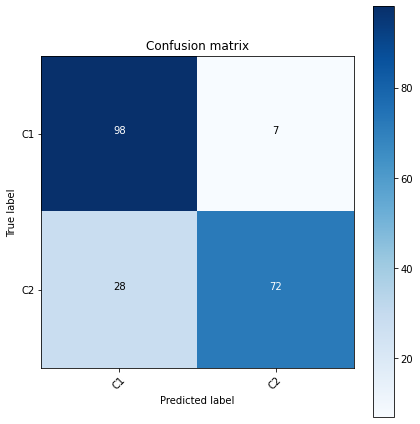

In [17]:
fig = plt.gcf()
fig.set_size_inches(6, 6)
cnf_matrix = confusion_matrix(y_validation_cls, y_validation_predict_cls)
plot_confusion_matrix(cnf_matrix, [f'C{i+1}' for i in range(num_classes)], 
                      title='Confusion matrix', normalize=False)

from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

predicted = model.predict(x_test)
for i in range(len(predicted)):
    predicted[i] = np.around(predicted[i])
    
recall = recall_score(y_test, predicted, average=None)
precision = precision_score(y_test, predicted, average=None)
accuracy = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted,  average=None)

print("Accuracy:\t", round(accuracy, 5))
print("Recall:\t\t", round(recall[0] ,5 ), '\t', round(recall[1] ,5 ))
print("Precision:\t", round(precision[0] ,5 ), '\t\t', round(precision[1] ,5 ))
print("F1:\t\t", round(f1[0] ,5 ), '\t', round(f1[1] ,5 ))